In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shwetanktripathi","key":"2ddac6c03f5c7a781207a3836a688770"}'}

In [2]:
# Install Kaggle API
!pip install kaggle

# Make directory for Kaggle configuration
!mkdir -p ~/.kaggle

# Move kaggle.json into the folder
!cp kaggle.json ~/.kaggle/

# Change permissions
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# List datasets available (optional)
!kaggle datasets list -s plantvillage

# Download the dataset
!kaggle datasets download -d 'emmarex/plantdisease'

# Unzip the dataset
!unzip plantdisease.zip -d plant_disease_dataset

Streaming output truncated to the last 5000 lines.
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf__

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 107MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/10
Training Loss: 2.3105 Validation Loss: 0.7690 Validation Accuracy: 0.8042
Epoch 2/10
Training Loss: 1.0994 Validation Loss: 0.4899 Validation Accuracy: 0.8675
Epoch 3/10
Training Loss: 0.7831 Validation Loss: 0.3905 Validation Accuracy: 0.8922
Epoch 4/10
Training Loss: 0.6354 Validation Loss: 0.3334 Validation Accuracy: 0.9004
Epoch 5/10
Training Loss: 0.5550 Validation Loss: 0.2922 Validation Accuracy: 0.9106
Epoch 6/10
Training Loss: 0.4904 Validation Loss: 0.2826 Validation Accuracy: 0.9169
Epoch 7/10
Training Loss: 0.4850 Validation Loss: 0.2776 Validation Accuracy: 0.9188
Epoch 8/10
Training Loss: 0.4797 Validation Loss: 0.2765 Validation Accuracy: 0.9171
Epoch 9/10
Training Loss: 0.4666 Validation Loss: 0.2741 Validation Accuracy: 0.9140
Epoch 10/10
Training Loss: 0.4588 Validation Loss: 0.2693 Validation Accuracy: 0.9222


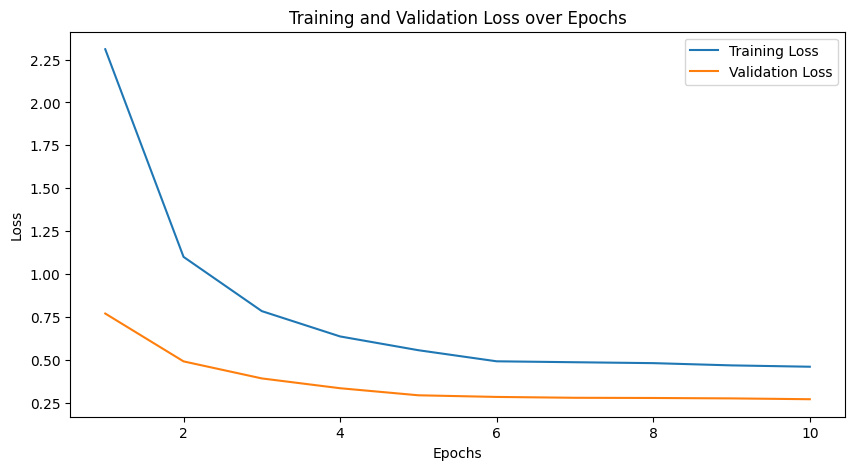

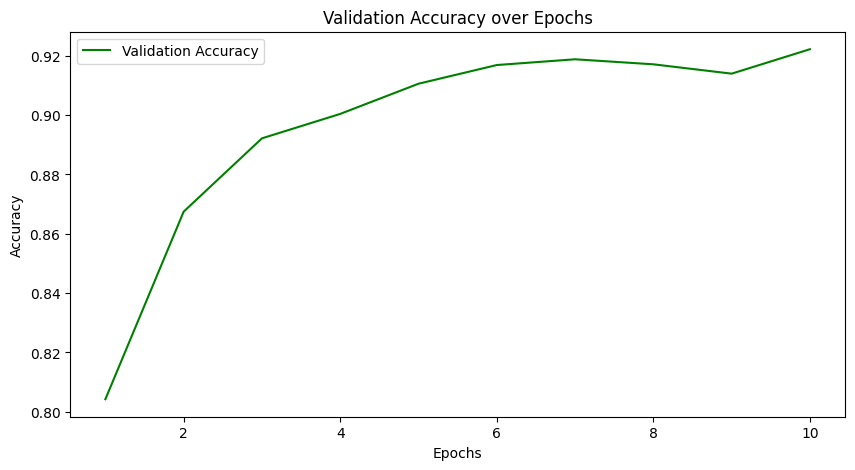

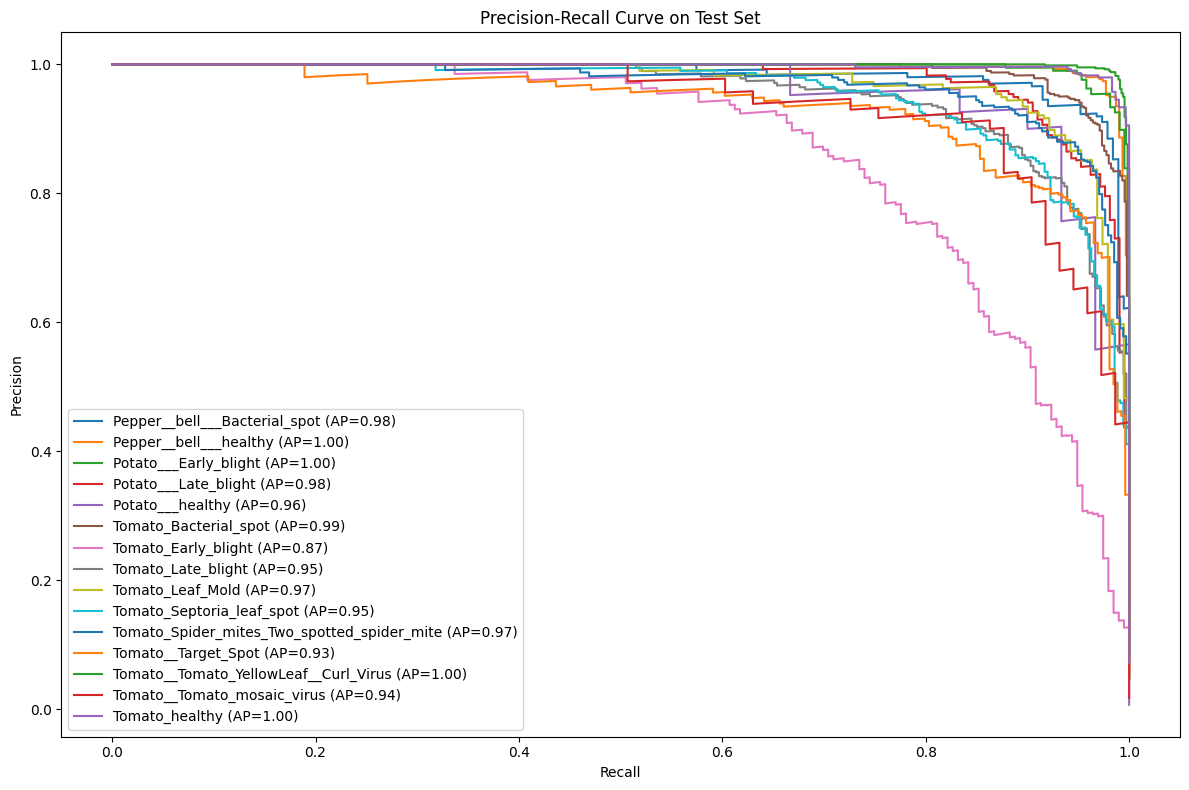

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import os

def main():
    # Directory containing all the data with class subdirectories
    data_dir = '/content/plant_disease_dataset/PlantVillage'  # Adjust the path if needed

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data transformations
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load the entire dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

    # Split the dataset into train (60%), val (20%), test (20%)
    dataset_size = len(full_dataset)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Set random seed for reproducibility
    torch.manual_seed(42)

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Data loaders
    batch_size = 32
    num_workers = 2  # Adjust based on your environment
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Load the pre-trained GoogLeNet model with aux_logits=True
    from torchvision.models import googlenet, GoogLeNet_Weights
    weights = GoogLeNet_Weights.IMAGENET1K_V1

    model = googlenet(weights=weights, aux_logits=True)

    num_classes = len(full_dataset.classes)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last few layers (e.g., 'inception5b', 'fc', and auxiliary classifiers)
    for name, param in model.named_parameters():
        if ('inception5b' in name) or ('fc' in name) or ('aux' in name):
            param.requires_grad = True

    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Update auxiliary classifiers
    model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Include all trainable parameters in the optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

    # Learning rate scheduler
    from torch.optim.lr_scheduler import StepLR
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Training parameters
    epochs = 10
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, aux_outputs2, aux_outputs1 = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs1, labels)
            loss3 = criterion(aux_outputs2, labels)
            loss = loss1 + 0.3 * (loss2 + loss3)  # Weighted sum of losses
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)

        # Validation step
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)  # Only main output during evaluation
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_dataset)
        val_acc = val_running_corrects.double() / len(val_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {epoch_loss:.4f} Validation Loss: {val_loss:.4f} Validation Accuracy: {val_acc:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    # Evaluate on test set and plot PR curves
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)  # Only main output during evaluation
            probs = torch.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute Precision-Recall curve and Average Precision for each class
    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        y_true = (all_labels == i).astype(int)
        y_scores = all_probs[:, i]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        average_precision = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f'{full_dataset.classes[i]} (AP={average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve on Test Set')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()